In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam/spam.csv
/kaggle/input/sms-spam-collection-dataset/spam.csv


This initial portion of the project was done with assistance from https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8

In [2]:
# import libraries for reading data, exploring and plotting
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

Setting up the dataframe from the csv:

In [3]:
messages = pd.read_csv('/kaggle/input/sms-spam/spam.csv', encoding = "ISO-8859-1")
messages.drop(messages.columns[[2,3,4]], axis=1, inplace=True)
messages.rename(columns={"v1":"label","v2":"message"}, inplace=True)
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
messages.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


Seperate out ham and spam messages, where ham are normal messages and spam are, well... spam.

In [5]:
# Get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

In order to better visualize what the text sets consist of, WordClouds can be generated of both the ham and spam datasets.

# WordCloud of ham

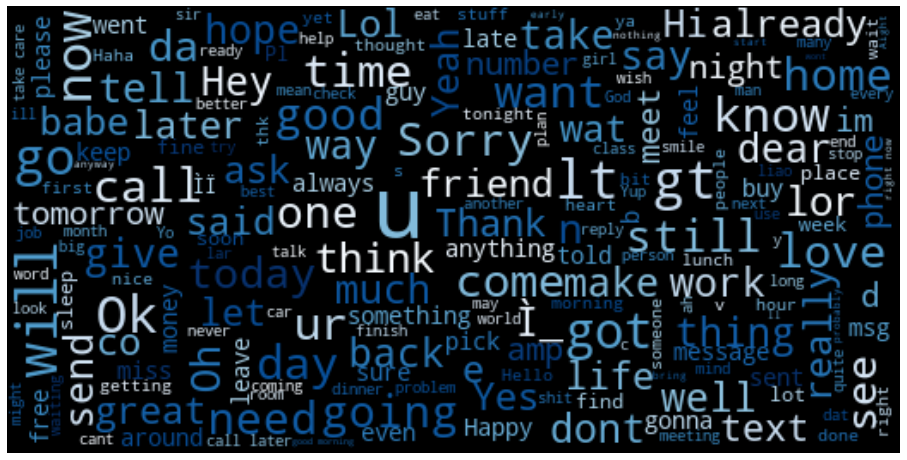

In [6]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

# WordCloud of spam

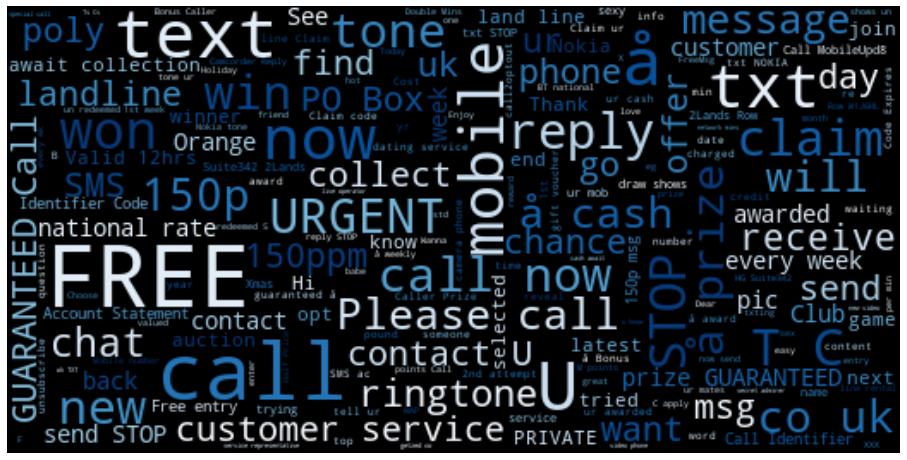

In [7]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

We can also view the distribution in our dataset of ham vs spam:

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

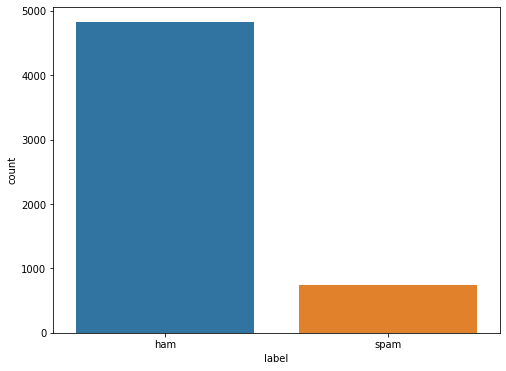

In [8]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

An imbalanced dataset would mean that our model would be substantially less likely to be trained on spam data vs ham data if not accounted for by either resampling the training sets or using different evaluation metrics than a random sample from the dataset.

In [9]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 1)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

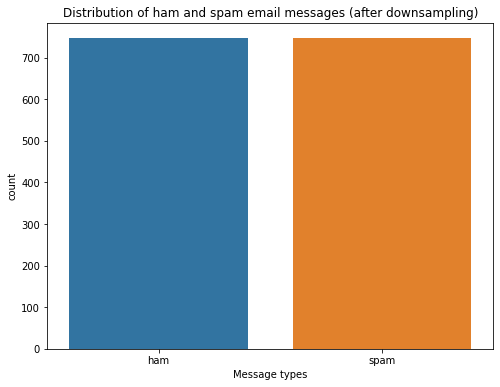

In [10]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

We can see now that our dataset is now balanced. We can additionally view a new wordcloud of our ham and compare that to the above:

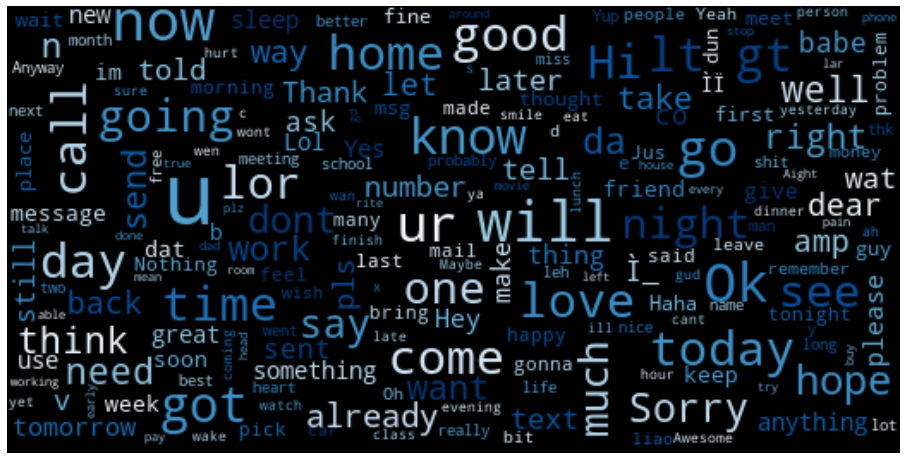

In [11]:
ham_msg_df_text = " ".join(ham_msg_df.message.to_numpy().tolist())
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_df_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

In [12]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,70.145917
spam,138.866131


# PROJECT PART 2 STARTS HERE

In [13]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=703)

Now we need to tokenize the data. Using Tokenizer there are 6 main pre-processing hyperparameters.

1. num_words: describes how many words we want our tokenizer's vocabulary to actually consist of, and the guide I am following recommends 500. This means that 500 unique words will be allowed as part of our vocabulary from our training and test data, and anything else can then be considered out of vocabulary.

2. oov_token: this token will replace any words not in our vocabulary, so word 501 and beyond will be replaced with whatever the input of this parameter is.

3. char_level: char_level when true states that our tokenizer should consider each individual character a token, we do not want this so it will be set to false.

4. maxlen: decides the largest a sentence should be, in this case the tutorial recommends a length of 50 words.

5. padding: pre or post, decides if a sentence is less than the 50 word maxlen then it will be padded so that all of our sentences are of an equal length.

6. truncating: pre or post, decides if a sentence is longer than the 50 word maxlen if it should be truncated from the beginning (pre) or end (post) of the sentence

In [14]:
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500
char_level = False

Now we apply hyper-parameters to our tokenizer and fit our training messages to tokenize the words within the dataset.

In [15]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=char_level, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

word_index = tokenizer.word_index
unique_words = len(word_index)
print('There are %s unique tokens in training data. ' % unique_words)

There are 4100 unique tokens in training data. 


In [16]:
uniq_words = pd.DataFrame([word_index])
uniq_words.head()

,<OOV>,to,you,a,the,i,call,u,your,for,...,bus8,65,61,66,382,cres,tech,6ph,5wkg,ì¬n
0,1,2,3,4,5,6,7,8,9,10,...,4091,4092,4093,4094,4095,4096,4097,4098,4099,4100


Tokenizer's texts_to_sequences allows us to build the sentences as an array of token indexes in reference to our word_index built in the previous cell.

In [17]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type)

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)
print(training_padded)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)
[[  1   1   1 ...   0   0   0]
 [323   9 409 ...   0   0   0]
 [  1 234   1 ...   0   0   0]
 ...
 [ 78   1   2 ...   0   0   0]
 [  1  36 144 ...   0   0   0]
 [  1   1   5 ...   0   0   0]]


In [18]:
print(testing_padded)

[[170  10   5 ...   0   0   0]
 [  8  19   4 ...   0   0   0]
 [  1  30 118 ...   0   0   0]
 ...
 [  6 159  70 ...   0   0   0]
 [254 124   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]]


In [19]:
from sklearn.ensemble import RandomForestClassifier

simple_model60 = RandomForestClassifier(n_estimators = 60, random_state = 50)
simple_model80 = RandomForestClassifier(n_estimators = 80, random_state = 50)
simple_model100 = RandomForestClassifier(n_estimators = 100, random_state = 50)
simple_model120 = RandomForestClassifier(n_estimators = 120, random_state = 50)

simple_model60.fit(training_padded, train_labels)
simple_model80.fit(training_padded, train_labels)
simple_model100.fit(training_padded, train_labels)
simple_model120.fit(training_padded, train_labels)

RandomForestClassifier(n_estimators=120, random_state=50)

In [20]:
from sklearn import metrics

predictions60 = simple_model60.predict(testing_padded)
predictions80 = simple_model80.predict(testing_padded)
predictions100 = simple_model100.predict(testing_padded)
predictions120 = simple_model120.predict(testing_padded)

print("ACCURACY OF MODEL WITH 60 EPOCHS: ", metrics.accuracy_score(predictions60,test_labels))
print("ACCURACY OF MODEL WITH 80 EPOCHS: ", metrics.accuracy_score(predictions80,test_labels))
print("ACCURACY OF MODEL WITH 100 EPOCHS: ", metrics.accuracy_score(predictions100,test_labels))
print("ACCURACY OF MODEL WITH 120 EPOCHS: ", metrics.accuracy_score(predictions120,test_labels))

#I decided to test the 3 models at each different number of iterations with two sort of spam messages I have written myself (index 0 and 1 below) and a third message marked as spam by my phone last week (index 2 below)
fun_test = tokenizer.texts_to_sequences(["Hey,would you like to buy some gold? Visit www.gold4free.com to claim your FREE gold today!","Click here to send money to political organization", "URGENT CORRECTION - Election day is TODAY. If you have not already, please get out to the polls to make your voice heard! STOP to opt out."])
fun_test_padded = pad_sequences(fun_test, maxlen = max_len, padding = padding_type, truncating = trunc_type)
print()
print("60 epochs predicts: ", simple_model60.predict(fun_test_padded))
print("80 epochs predicts: ", simple_model80.predict(fun_test_padded))
print("100 epochs predicts: ", simple_model100.predict(fun_test_padded))
print("120 epochs predicts: ", simple_model120.predict(fun_test_padded))

ACCURACY OF MODEL WITH 60 EPOCHS:  0.8394648829431438
ACCURACY OF MODEL WITH 80 EPOCHS:  0.8394648829431438
ACCURACY OF MODEL WITH 100 EPOCHS:  0.8461538461538461
ACCURACY OF MODEL WITH 120 EPOCHS:  0.842809364548495

60 epochs predicts:  [0 0 1]
80 epochs predicts:  [0 0 1]
100 epochs predicts:  [0 0 1]
120 epochs predicts:  [0 0 1]


Interestingly, my fake spam are both identified as legitimate while the actual spam message is flagged by all levels of training. We can see that the accuracy when predicting spam or not is maximized at 100 epochs among these options, so were we to utilize a randomforestclassifier model then 100 epochs would be our choice.

# PROJECT PART 3 STARTS HERE

We will now define our hyperparameters and use a Sequential model with added features such as activation layers, embedding, global average pooling and dropout to create our Dense Model.

In [21]:
#Hyperparameter values
embedding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

#model architecture
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

#View a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


2022-12-01 18:23:37.147019: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We need to compile our model, so we will specify our loss function as binary crossentropy because there are only two outcomes (ham vs spam) and then use accuracy as our measure of model success. The optimizer used will be Adam, as it is a combination of gradient descent with momentum and root mean square progression, which allows the model to avoid getting trapped by local minima.

In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

We can now fit our model with our data. We can use early stopping to monitor the validation loss, which with a patience of X will stop our fitting if the model sees X epochs without an improvement. 

In [23]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history1 = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30


2022-12-01 18:23:37.367737: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


38/38 - 1s - loss: 0.6857 - accuracy: 0.6092 - val_loss: 0.6761 - val_accuracy: 0.7960
Epoch 2/30
38/38 - 0s - loss: 0.6603 - accuracy: 0.7908 - val_loss: 0.6389 - val_accuracy: 0.8495
Epoch 3/30
38/38 - 0s - loss: 0.6057 - accuracy: 0.8427 - val_loss: 0.5671 - val_accuracy: 0.8696
Epoch 4/30
38/38 - 0s - loss: 0.5214 - accuracy: 0.8720 - val_loss: 0.4814 - val_accuracy: 0.8729
Epoch 5/30
38/38 - 0s - loss: 0.4301 - accuracy: 0.8820 - val_loss: 0.4015 - val_accuracy: 0.8763
Epoch 6/30
38/38 - 0s - loss: 0.3605 - accuracy: 0.8954 - val_loss: 0.3379 - val_accuracy: 0.8829
Epoch 7/30
38/38 - 0s - loss: 0.2986 - accuracy: 0.9113 - val_loss: 0.2910 - val_accuracy: 0.8930
Epoch 8/30
38/38 - 0s - loss: 0.2527 - accuracy: 0.9247 - val_loss: 0.2536 - val_accuracy: 0.8963
Epoch 9/30
38/38 - 0s - loss: 0.2153 - accuracy: 0.9331 - val_loss: 0.2208 - val_accuracy: 0.9130
Epoch 10/30
38/38 - 0s - loss: 0.1836 - accuracy: 0.9448 - val_loss: 0.1980 - val_accuracy: 0.9231
Epoch 11/30
38/38 - 0s - loss:

In [24]:
model.predict(fun_test_padded)

array([[0.9826466 ],
       [0.24114999],
       [0.9855014 ]], dtype=float32)

In [25]:
#Hyperparameter values
embeding_dim = 16
drop_value = 0.1 # dropout
n_dense = 30

#model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

#View a summary of our model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 8,541
Trainable params: 8,541
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [27]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history2 = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6913 - accuracy: 0.5515 - val_loss: 0.6846 - val_accuracy: 0.8696
Epoch 2/30
38/38 - 0s - loss: 0.6714 - accuracy: 0.8862 - val_loss: 0.6534 - val_accuracy: 0.8729
Epoch 3/30
38/38 - 0s - loss: 0.6184 - accuracy: 0.8962 - val_loss: 0.5813 - val_accuracy: 0.8796
Epoch 4/30
38/38 - 0s - loss: 0.5196 - accuracy: 0.8996 - val_loss: 0.4679 - val_accuracy: 0.8863
Epoch 5/30
38/38 - 0s - loss: 0.3961 - accuracy: 0.9146 - val_loss: 0.3567 - val_accuracy: 0.8896
Epoch 6/30
38/38 - 0s - loss: 0.3000 - accuracy: 0.9264 - val_loss: 0.2823 - val_accuracy: 0.8997
Epoch 7/30
38/38 - 0s - loss: 0.2335 - accuracy: 0.9356 - val_loss: 0.2339 - val_accuracy: 0.9197
Epoch 8/30
38/38 - 0s - loss: 0.1853 - accuracy: 0.9523 - val_loss: 0.2021 - val_accuracy: 0.9231
Epoch 9/30
38/38 - 0s - loss: 0.1569 - accuracy: 0.9590 - val_loss: 0.1832 - val_accuracy: 0.9331
Epoch 10/30
38/38 - 0s - loss: 0.1325 - accuracy: 0.9649 - val_loss: 0.1648 - val_accuracy: 0.9365
Epoch 11/30
38/38 -

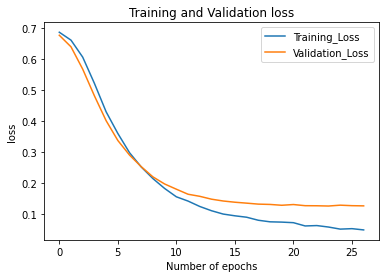

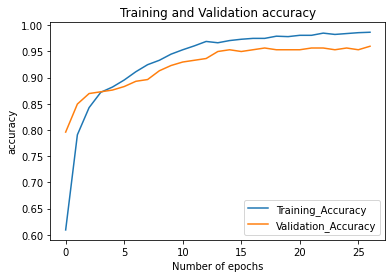

In [28]:
# Read as a dataframe 
metrics = pd.DataFrame(history1.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

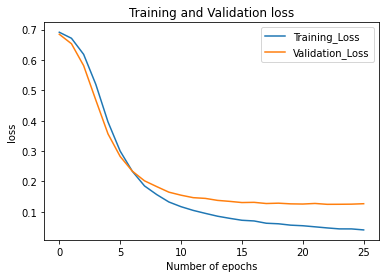

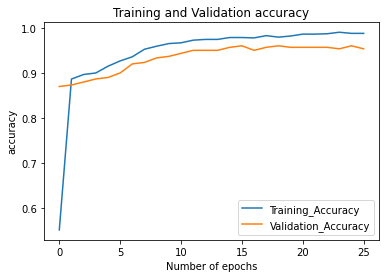

In [29]:
# Read as a dataframe 
metrics = pd.DataFrame(history2.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [30]:
#Hyperparameter values
embeding_dim = 16
drop_value = 0.0 # dropout
n_dense = 30

#model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

#View a summary of our model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 8,541
Trainable params: 8,541
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [32]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history3 = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6839 - accuracy: 0.7766 - val_loss: 0.6714 - val_accuracy: 0.8294
Epoch 2/30
38/38 - 0s - loss: 0.6508 - accuracy: 0.8410 - val_loss: 0.6237 - val_accuracy: 0.8595
Epoch 3/30
38/38 - 0s - loss: 0.5826 - accuracy: 0.8845 - val_loss: 0.5407 - val_accuracy: 0.8763
Epoch 4/30
38/38 - 0s - loss: 0.4836 - accuracy: 0.8954 - val_loss: 0.4415 - val_accuracy: 0.8829
Epoch 5/30
38/38 - 0s - loss: 0.3839 - accuracy: 0.9046 - val_loss: 0.3563 - val_accuracy: 0.8863
Epoch 6/30
38/38 - 0s - loss: 0.3050 - accuracy: 0.9172 - val_loss: 0.2952 - val_accuracy: 0.8963
Epoch 7/30
38/38 - 0s - loss: 0.2456 - accuracy: 0.9297 - val_loss: 0.2508 - val_accuracy: 0.9064
Epoch 8/30
38/38 - 0s - loss: 0.2017 - accuracy: 0.9439 - val_loss: 0.2151 - val_accuracy: 0.9197
Epoch 9/30
38/38 - 0s - loss: 0.1677 - accuracy: 0.9523 - val_loss: 0.1917 - val_accuracy: 0.9264
Epoch 10/30
38/38 - 0s - loss: 0.1421 - accuracy: 0.9590 - val_loss: 0.1734 - val_accuracy: 0.9331
Epoch 11/30
38/38 -

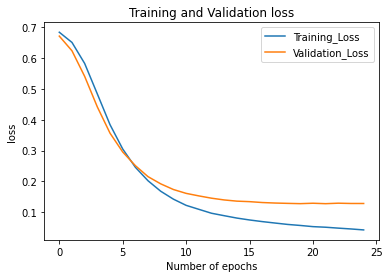

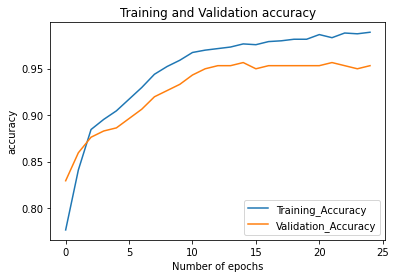

In [33]:
# Read as a dataframe 
metrics = pd.DataFrame(history3.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)

def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

The larger spread between training and validation on both loss and accuracy shows that dropout is important.